# Future Prediction

## Overview
This notebook demonstrates how to use our trained machine learning model to generate future sales predictions for different product categories. We'll walk through the entire prediction pipeline:

1. **Data Preparation**: Loading historical data and setting up forecast parameters
2. **Feature Engineering**: Generating model-ready features for future dates
3. **Model Inference**: Using our trained model to predict future sales
4. **Visualization & Analysis**: Examining prediction results and trends
5. **Forecast Evaluation**: Assessing the quality of our predictions

These forecasts can help businesses make data-driven decisions about inventory management, staffing, and financial planning.


In [5]:
# Import required libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colormaps
import seaborn as sns
from datetime import timedelta
import logging

# Import custom modules
from src.feature_engineering.feature_builder import FeatureBuilder
from src.db_operations import get_historical_sales, store_predictions

# Set plot style for professional visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## 1. Load Model and Historical Data

First, we load our trained model and the required feature columns. The model was trained in the previous notebook (`03_model_training.ipynb`) and saved to disk. We also load historical sales data to use as a baseline for our predictions.


In [6]:
# Define paths
MODEL_PATH = '../model/model.pkl'
FEATURE_COLUMNS_PATH = '../model/feature_columns.pkl'
HISTORICAL_DATA_PATH = '../data/processed/sales_engineered_features.csv'

# Load trained model
try:
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)
    print(f"Successfully loaded model from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Load required feature columns
try:
    with open(FEATURE_COLUMNS_PATH, 'rb') as f:
        feature_columns = pickle.load(f)
    print(f"Successfully loaded {len(feature_columns)} feature columns")
except Exception as e:
    print(f"Error loading feature columns: {e}")
    raise

# Load historical data
try:
    full_data = pd.read_csv(HISTORICAL_DATA_PATH, parse_dates=['date'], index_col='date')
    full_data = full_data.sort_index()
    print(f"Loaded historical data with {len(full_data)} rows from {full_data.index.min()} to {full_data.index.max()}")
except Exception as e:
    print(f"Error loading historical data: {e}")
    raise

# Display information about the historical data
print(f"Historical data shape: {full_data.shape}")
print(f"Date range: {full_data.index.min()} to {full_data.index.max()}")
print(f"Categories: {', '.join([col for col in full_data.columns if col in ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']])}")

# Display sample of historical data
full_data[['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']].tail()

Successfully loaded model from ../model/model.pkl
Successfully loaded 169 feature columns
Loaded historical data with 1798 rows from 2020-06-05 00:00:00 to 2025-05-07 00:00:00
Historical data shape: (1798, 185)
Date range: 2020-06-05 00:00:00 to 2025-05-07 00:00:00
Categories: Beauty, Books, Clothing, Electronics, Furniture, Groceries, Sports, Toys


,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys
date,,,,,,,,
2025-05-03,4466.09,3414.43,5482.39,1676.84,1219.80,2274.59,2656.71,2721.31
2025-05-04,4013.67,2921.58,6091.02,1890.71,2420.20,2194.25,2552.81,2695.07
2025-05-05,4132.51,2490.60,5136.57,1204.61,1437.99,2164.47,2645.81,2569.67
2025-05-06,4101.22,2500.62,4470.40,2570.00,1646.31,1949.27,2767.66,2274.70
2025-05-07,4550.94,2798.59,4624.40,1557.07,2710.36,2312.89,2383.78,2271.58


## 2. Configure Forecast Parameters

We need to define the time period for which we want to generate predictions. We'll start from the day after our last historical data point and forecast for a specified number of days into the future.


In [7]:
# Define forecast parameters
FORECAST_DAYS = 30  # Number of days to forecast

# Determine start and end dates for forecasting
forecast_start_date = full_data.index.max() + timedelta(days=1)
forecast_end_date = forecast_start_date + timedelta(days=FORECAST_DAYS-1)

print(f"Forecast period: {forecast_start_date.strftime('%Y-%m-%d')} to {forecast_end_date.strftime('%Y-%m-%d')} ({FORECAST_DAYS} days)")

Forecast period: 2025-05-08 to 2025-06-06 (30 days)


## 3. Generate Features for Future Dates

Now we'll use our `FeatureBuilder` class to generate the features needed for prediction. This class handles all the complex feature engineering, including creating lag features and date-based features.


In [8]:
# Initialize the FeatureBuilder
builder = FeatureBuilder()

# Generate future features
print(f"Generating features for {forecast_start_date} to {forecast_end_date}")
future_features = builder.generate_features(
    start_date=forecast_start_date.strftime('%Y-%m-%d'),
    end_date=forecast_end_date.strftime('%Y-%m-%d'),
    historical_data=full_data
)
print(f"Successfully generated features with shape {future_features.shape}")
# Display the first few rows of features
print(f"Generated {len(future_features)} days of features with {future_features.shape[1]} columns")
future_features.head()

Generating features for 2025-05-08 00:00:00 to 2025-06-06 00:00:00
Successfully generated features with shape (30, 169)
Generated 30 days of features with 169 columns


,Beauty_lag_1d,Books_lag_1d,Clothing_lag_1d,Electronics_lag_1d,Furniture_lag_1d,Groceries_lag_1d,Sports_lag_1d,Toys_lag_1d,Beauty_units_lag_1d,Books_units_lag_1d,Clothing_units_lag_1d,Electronics_units_lag_1d,Furniture_units_lag_1d,Groceries_units_lag_1d,Sports_units_lag_1d,Toys_units_lag_1d,Beauty_lag_7d,Books_lag_7d,Clothing_lag_7d,Electronics_lag_7d,Furniture_lag_7d,Groceries_lag_7d,Sports_lag_7d,Toys_lag_7d,Beauty_units_lag_7d,Books_units_lag_7d,Clothing_units_lag_7d,Electronics_units_lag_7d,Furniture_units_lag_7d,Groceries_units_lag_7d,Sports_units_lag_7d,Toys_units_lag_7d,Beauty_lag_14d,Books_lag_14d,Clothing_lag_14d,Electronics_lag_14d,Furniture_lag_14d,Groceries_lag_14d,Sports_lag_14d,Toys_lag_14d,Beauty_units_lag_14d,Books_units_lag_14d,Clothing_units_lag_14d,Electronics_units_lag_14d,Furniture_units_lag_14d,Groceries_units_lag_14d,Sports_units_lag_14d,Toys_units_lag_14d,Beauty_lag_28d,Books_lag_28d,Clothing_lag_28d,Electronics_lag_28d,Furniture_lag_28d,Groceries_lag_28d,Sports_lag_28d,Toys_lag_28d,Beauty_units_lag_28d,Books_units_lag_28d,Clothing_units_lag_28d,Electronics_units_lag_28d,Furniture_units_lag_28d,Groceries_units_lag_28d,Sports_units_lag_28d,Toys_units_lag_28d,Beauty_rolling_avg_7d,Books_rolling_avg_7d,Clothing_rolling_avg_7d,Electronics_rolling_avg_7d,Furniture_rolling_avg_7d,Groceries_rolling_avg_7d,Sports_rolling_avg_7d,Toys_rolling_avg_7d,Beauty_units_rolling_avg_7d,Books_units_rolling_avg_7d,Clothing_units_rolling_avg_7d,Electronics_units_rolling_avg_7d,Furniture_units_rolling_avg_7d,Groceries_units_rolling_avg_7d,Sports_units_rolling_avg_7d,Toys_units_rolling_avg_7d,Beauty_rolling_avg_14d,Books_rolling_avg_14d,Clothing_rolling_avg_14d,Electronics_rolling_avg_14d,Furniture_rolling_avg_14d,Groceries_rolling_avg_14d,Sports_rolling_avg_14d,Toys_rolling_avg_14d,Beauty_units_rolling_avg_14d,Books_units_rolling_avg_14d,Clothing_units_rolling_avg_14d,Electronics_units_rolling_avg_14d,Furniture_units_rolling_avg_14d,Groceries_units_rolling_avg_14d,Sports_units_rolling_avg_14d,Toys_units_rolling_avg_14d,Beauty_rolling_avg_28d,Books_rolling_avg_28d,Clothing_rolling_avg_28d,Electronics_rolling_avg_28d,Furniture_rolling_avg_28d,Groceries_rolling_avg_28d,Sports_rolling_avg_28d,Toys_rolling_avg_28d,Beauty_units_rolling_avg_28d,Books_units_rolling_avg_28d,Clothing_units_rolling_avg_28d,Electronics_units_rolling_avg_28d,Furniture_units_rolling_avg_28d,Groceries_units_rolling_avg_28d,Sports_units_rolling_avg_28d,Toys_units_rolling_avg_28d,Beauty_rolling_std_7d,Books_rolling_std_7d,Clothing_rolling_std_7d,Electronics_rolling_std_7d,Furniture_rolling_std_7d,Groceries_rolling_std_7d,Sports_rolling_std_7d,Toys_rolling_std_7d,Beauty_units_rolling_std_7d,Books_units_rolling_std_7d,Clothing_units_rolling_std_7d,Electronics_units_rolling_std_7d,Furniture_units_rolling_std_7d,Groceries_units_rolling_std_7d,Sports_units_rolling_std_7d,Toys_units_rolling_std_7d,Beauty_rolling_std_14d,Books_rolling_std_14d,Clothing_rolling_std_14d,Electronics_rolling_std_14d,Furniture_rolling_std_14d,Groceries_rolling_std_14d,Sports_rolling_std_14d,Toys_rolling_std_14d,Beauty_units_rolling_std_14d,Books_units_rolling_std_14d,Clothing_units_rolling_std_14d,Electronics_units_rolling_std_14d,Furniture_units_rolling_std_14d,Groceries_units_rolling_std_14d,Sports_units_rolling_std_14d,Toys_units_rolling_std_14d,Beauty_rolling_std_28d,Books_rolling_std_28d,Clothing_rolling_std_28d,Electronics_rolling_std_28d,Furniture_rolling_std_28d,Groceries_rolling_std_28d,Sports_rolling_std_28d,Toys_rolling_std_28d,Beauty_units_rolling_std_28d,Books_units_rolling_std_28d,Clothing_units_rolling_std_28d,Electronics_units_rolling_std_28d,Furniture_units_rolling_std_28d,Groceries_units_rolling_std_28d,Sports_units_rolling_std_28d,Toys_units_rolling_std_28d,year,month,day_of_week,week_of_year,quarter,is_weekend,is_month_end,is_month_start,is_november
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

## 4. Make Predictions

With our features prepared, we can now use our trained model to make predictions for future sales across all product categories.


In [9]:
# Define target categories
target_categories = ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']

# Make predictions
print("Making predictions with the model")
preds = model.predict(future_features)

# Convert predictions to DataFrame
predicted_df = pd.DataFrame(
    preds,
    index=future_features.index,
    columns=target_categories
)

print(f"Successfully generated predictions for {len(predicted_df)} days")

# Add total sales column
predicted_df['total_sales'] = predicted_df[target_categories].sum(axis=1)

# Display predictions
print(f"Prediction summary statistics:")
print(predicted_df.describe())

# Display the first few rows of predictions
predicted_df.head()

Making predictions with the model
Successfully generated predictions for 30 days
Prediction summary statistics:
        Beauty    Books  Clothing  Electronics  Furniture  Groceries   Sports     Toys  total_sales
count    30.00    30.00     30.00        30.00      30.00      30.00    30.00    30.00        30.00
mean   4862.10  3213.57   5533.97      2546.70    1706.67    2385.24  2932.24  2756.43     25936.93
std     210.48   125.76    224.54       168.14      72.85      80.76   101.74    66.08       946.02
min    4629.79  3046.64   5261.40      2374.78    1570.17    2301.27  2781.33  2657.42     25097.41
25%    4721.88  3102.93   5387.22      2419.45    1663.36    2335.90  2871.00  2709.27     25295.12
50%    4767.35  3202.83   5439.16      2492.55    1733.62    2347.27  2908.18  2749.39     25457.17
75%    5031.81  3273.11   5733.60      2638.70    1751.70    2421.65  3001.40  2792.06     26800.67
max    5294.20  3449.14   5959.01      2920.36    1846.96    2563.70  3121.29  2910.94  

,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys,total_sales
date,,,,,,,,,
2025-05-08,4700.98,3206.05,5413.60,2546.06,1682.64,2323.34,2942.00,2772.59,25587.25
2025-05-09,4724.10,3046.64,5386.72,2490.06,1615.64,2301.27,2905.77,2681.28,25151.49
2025-05-10,5152.24,3395.61,5903.31,2920.36,1735.75,2434.74,3036.91,2825.21,27404.13
2025-05-11,5093.01,3443.23,5808.11,2821.11,1747.94,2541.17,3083.23,2910.94,27448.74
2025-05-12,4668.60,3110.11,5426.66,2375.37,1692.84,2382.36,2785.37,2711.64,25152.95


## 5. Visualize Predictions

Let's create visualizations to better understand our predictions and how they relate to historical data.

### 5.1 Top Categories Forecast

First, we'll plot the historical and predicted sales for the top categories.


Top 3 categories by average sales: Clothing, Beauty, Books


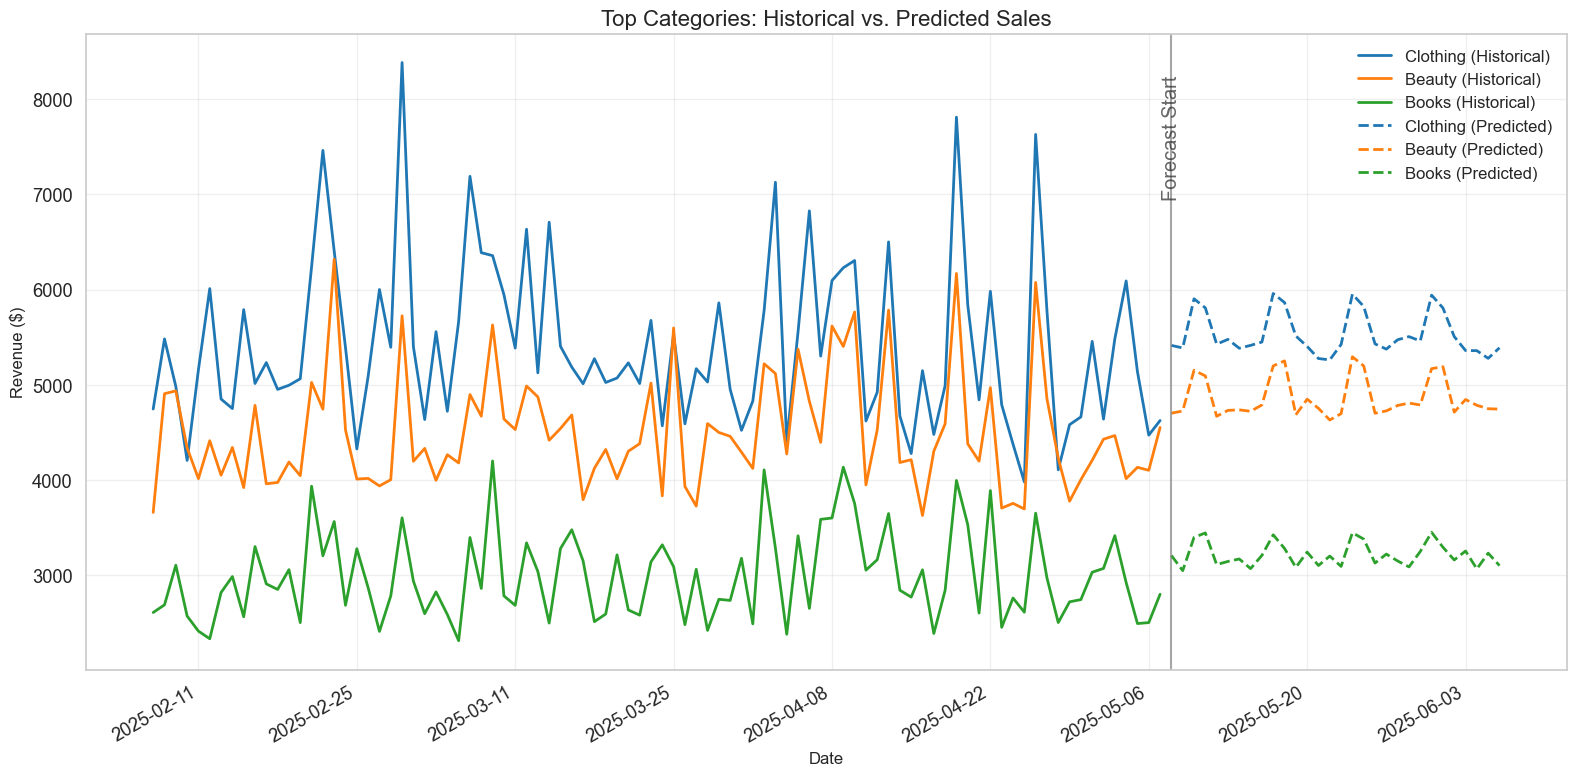

In [10]:
# Identify top categories by average sales
top_categories = full_data[target_categories].mean().sort_values(ascending=False).head(3).index.tolist()
print(f"Top 3 categories by average sales: {', '.join(top_categories)}")

# Plot historical and predicted data for top categories
plt.figure(figsize=(16, 8))

# Assign consistent colors using a color map
color_map = colormaps.get_cmap('tab10')
category_colors = {cat: color_map(i) for i, cat in enumerate(top_categories)}

# Plot historical data (last 90 days)
historical_days = 90
for cat in top_categories:
    plt.plot(
        full_data.index[-historical_days:], 
        full_data[cat].tail(historical_days), 
        label=f'{cat} (Historical)', 
        linewidth=2,
        color=category_colors[cat]
    )

# Plot predicted data
for cat in top_categories:
    plt.plot(
        predicted_df.index, 
        predicted_df[cat], 
        label=f'{cat} (Predicted)', 
        linewidth=2, 
        linestyle='--',
        color=category_colors[cat]
    )

# Add vertical line to separate historical and predicted data
plt.axvline(x=forecast_start_date, color='gray', linestyle='-', alpha=0.7)
plt.text(forecast_start_date, plt.ylim()[1]*0.95, 'Forecast Start', 
         horizontalalignment='center', verticalalignment='top', rotation=90, alpha=0.7)

# Format the plot
plt.title('Top Categories: Historical vs. Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### 5.2 Total Sales Forecast

Now let's look at the total sales across all categories.


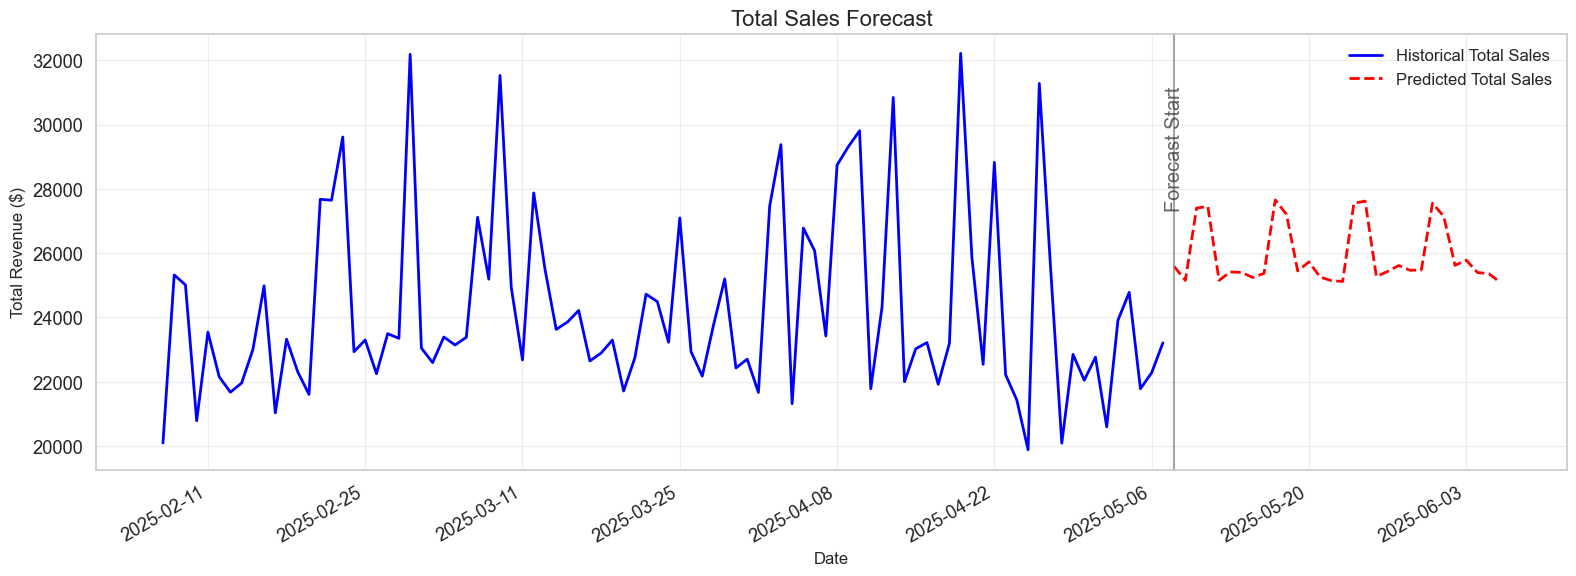

In [11]:
# Calculate total historical sales
full_data['total_sales'] = full_data[target_categories].sum(axis=1)

# Plot total sales
plt.figure(figsize=(16, 6))

# Plot historical total sales (last 90 days)
plt.plot(
    full_data.index[-historical_days:], 
    full_data['total_sales'].tail(historical_days), 
    label='Historical Total Sales', 
    color='blue', 
    linewidth=2
)

# Plot predicted total sales
plt.plot(
    predicted_df.index, 
    predicted_df['total_sales'], 
    label='Predicted Total Sales', 
    color='red', 
    linewidth=2, 
    linestyle='--'
)

# Add vertical line to separate historical and predicted data
plt.axvline(x=forecast_start_date, color='gray', linestyle='-', alpha=0.7)
plt.text(forecast_start_date, plt.ylim()[1]*0.95, 'Forecast Start', 
         horizontalalignment='center', verticalalignment='top', rotation=90, alpha=0.7)

# Format the plot
plt.title('Total Sales Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

## 6. Recursive Prediction

In [40]:
from datetime import timedelta
import numpy as np
import pandas as pd

# Make sure this matches your actual list
all_targets = ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']

# Lag/Roll calculator
def compute_lag_roll_std(df, date, col_base, lags=[1, 7, 14, 28], roll_windows=[7, 14, 28]):
    values = {}
    for lag in lags:
        lag_date = date - timedelta(days=lag)
        values[f"{col_base}_lag_{lag}d"] = df.at[lag_date, col_base] if lag_date in df.index else 0.0
    for window in roll_windows:
        dates = [date - timedelta(days=i) for i in range(1, window + 1)]
        past_vals = [df.at[d, col_base] for d in dates if d in df.index]
        values[f"{col_base}_rolling_avg_{window}d"] = float(np.mean(past_vals)) if past_vals else 0.0
        values[f"{col_base}_rolling_std_{window}d"] = float(np.std(past_vals)) if past_vals else 0.0
    return values

forecast_dates = pd.date_range(start=forecast_start_date, periods=30)

# Initialize frame to collect forecasted rows
predicted_rows = []

# This will act as a rolling window of data (actual + predicted)
combined_df = full_data.copy()

print(f"📅 Forecasting from {forecast_start_date} to {forecast_end_date}")

# Forecast loop
predicted_rows = []

for date in forecast_dates:
    row = {}

    # Calendar features
    row['year'] = date.year
    row['month'] = date.month
    row['day_of_week'] = date.weekday()
    row['week_of_year'] = date.isocalendar().week
    row['quarter'] = (date.month - 1) // 3 + 1
    row['is_weekend'] = int(date.weekday() >= 5)
    row['is_month_end'] = int(date.is_month_end)
    row['is_month_start'] = int(date.is_month_start)
    row['is_november'] = int(date.month == 11)

    # Compute lag/rolling features for each category
    for cat in categories:
        row.update(compute_lag_roll_std(combined_df, date, cat))
        row.update(compute_lag_roll_std(combined_df, date, f"{cat}_units"))

    # Build input with only features used during training
    X_input = pd.DataFrame([{col: row.get(col, 0.0) for col in feature_columns}], index=[date])

    # Predict
    y_pred = model.predict(X_input)[0]

    # Store predictions in combined_df (for use in future lags)
    for i, target in enumerate(all_targets):
        combined_df.at[date, target] = y_pred[i]

    # Track for export
    predicted_rows.append({'date': date, **{target: y_pred[i] for i, target in enumerate(all_targets)}})

print(f"Predicted for {len(predicted_rows)} days, total records in combined_df: {len(combined_df)}, total records in full_data: {len(full_data)}")

📅 Forecasting from 2025-05-08 00:00:00 to 2025-06-06 00:00:00
Predicted for 30 days, total records in combined_df: 1828, total records in full_data: 1798


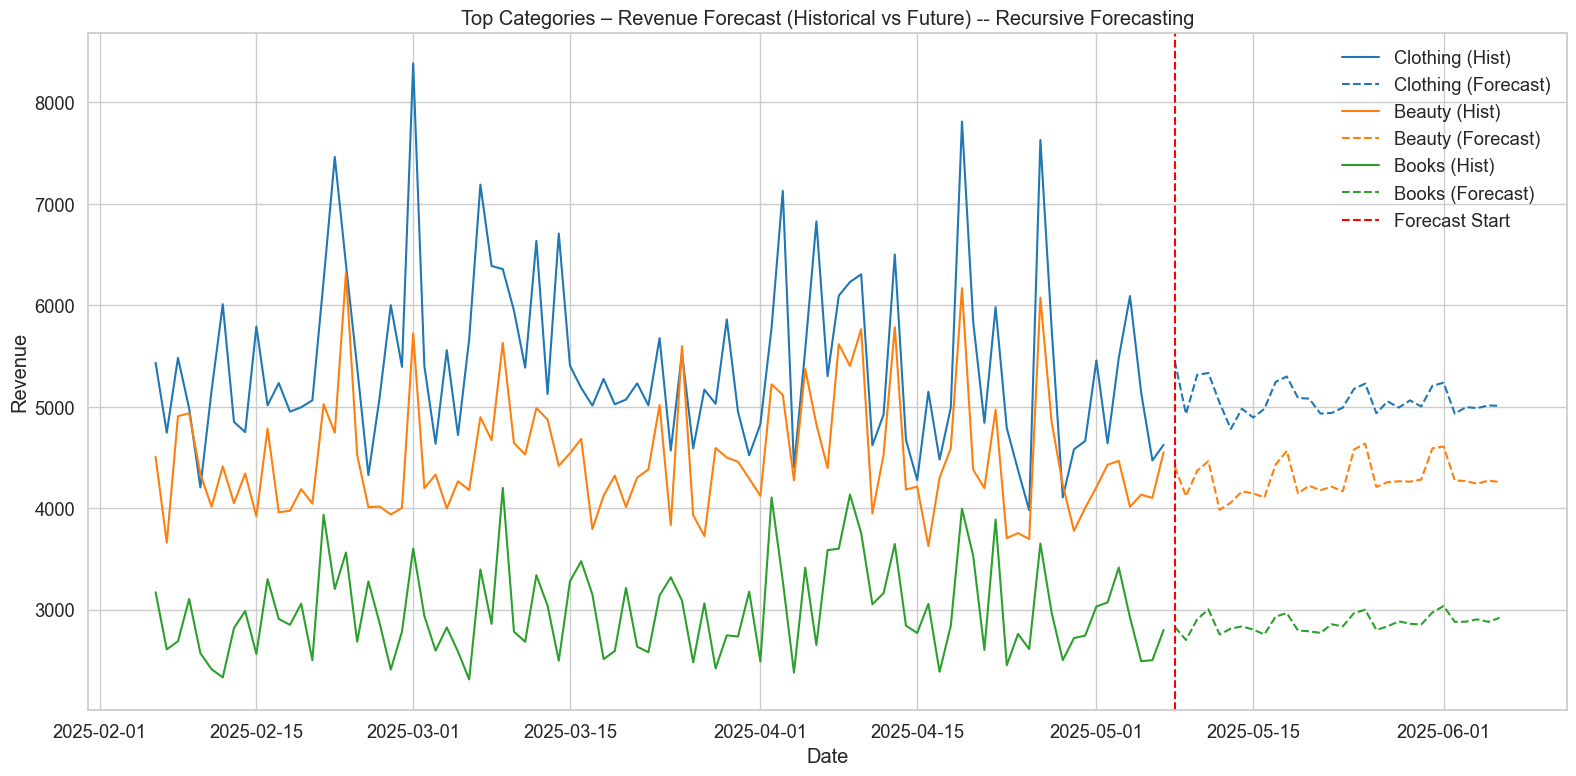

In [50]:
# Historical split
historical_end = full_data.index.max()
cutoff_date = historical_end - timedelta(days=90)

# Define color cycle for clarity
# Assign consistent colors using a color map
color_map = colormaps.get_cmap('tab10')
category_colors = {cat: color_map(i) for i, cat in enumerate(top_categories)}

plt.figure(figsize=(16, 8))

for i, cat in enumerate(top_categories):
    color = category_colors[cat]

    # Historical
    historical_series = combined_df.loc[cutoff_date:historical_end, cat]
    plt.plot(historical_series.index, historical_series, label=f"{cat} (Hist)", color=color, linestyle='-')

    # Forecast
    forecast_series = combined_df.loc[historical_end + timedelta(days=1):, cat]
    plt.plot(forecast_series.index, forecast_series, label=f"{cat} (Forecast)", color=color, linestyle='--')

# Forecast boundary
plt.axvline(x=historical_end + timedelta(days=1), color='red', linestyle='--', label='Forecast Start')

# Labels & legend
plt.title("Top Categories – Revenue Forecast (Historical vs Future) -- Recursive Forecasting")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Store Predictions in Database

Now that we've generated and analyzed our predictions, let's store them in the database for future use.


In [12]:
# Prepare predictions for database storage
db_predictions = predicted_df.reset_index()
db_predictions = db_predictions.rename(columns={'index': 'date'})

# Add required columns for the database
for col in ['year', 'month', 'day_of_week', 'is_weekend', 'week_of_year', 'quarter', 
            'is_month_end', 'is_month_start', 'is_november']:
    if col not in db_predictions.columns:
        if col == 'year':
            db_predictions[col] = db_predictions['date'].dt.year
        elif col == 'month':
            db_predictions[col] = db_predictions['date'].dt.month
        elif col == 'day_of_week':
            db_predictions[col] = db_predictions['date'].dt.dayofweek
        elif col == 'is_weekend':
            db_predictions[col] = (db_predictions['day_of_week'] >= 5).astype(int)
        elif col == 'week_of_year':
            db_predictions[col] = db_predictions['date'].dt.isocalendar().week
        elif col == 'quarter':
            db_predictions[col] = db_predictions['date'].dt.quarter
        elif col == 'is_month_end':
            db_predictions[col] = db_predictions['date'].dt.is_month_end.astype(int)
        elif col == 'is_month_start':
            db_predictions[col] = db_predictions['date'].dt.is_month_start.astype(int)
        elif col == 'is_november':
            db_predictions[col] = (db_predictions['date'].dt.month == 11).astype(int)

# Add lag columns required by the database schema
for category in target_categories:
    for lag in [1, 7, 14]:
        lag_col = f"{category}_lag_{lag}"
        if lag_col not in db_predictions.columns:
            db_predictions[lag_col] = 0  # Initialize with zeros

# Store predictions in database
# Uncomment the following lines to actually store the predictions
#rows_inserted = store_predictions(db_predictions, force=True)
#print(f"Successfully stored {rows_inserted} predictions in the database")

# For demonstration purposes only
#print(f"Prepared {len(db_predictions)} predictions for database storage")
#print("Database storage code is commented out. Uncomment to actually store predictions.")